In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from torchvision import transforms
import torch.optim as optim
from train import train_yolov2
import os
from model import model_builder
import lightnet as ln
import matplotlib.pyplot as plt
import numpy as np
from test_script import test_step
from utils import calculate_map

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_IMG_DIR = "data/data_split/test/images"
TEST_LABEL_DIR =  "data/data_split/test/labels"
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

print(f"Using Device {DEVICE}")

model = ln.models.YoloV2(NUM_CLASSES)
model.load('models/5_epochs_split.pt', strict=False)
model.to(DEVICE)

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)



Using Device cuda


/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [3]:
# test_step(
#     model=model,
#     dataloader=test_dataloader,
#     loss_fn=loss_fn,
#     device=DEVICE
# )

In [4]:
model_2 = ln.models.YoloV2(NUM_CLASSES)
model_2.load('models/5_epochs_split.pt', strict=False)

In [5]:
X, y = test_dataset[785]

In [6]:
model.eval()
with torch.inference_mode():
    model_output = model_2(X.unsqueeze(0))

In [7]:
to_pil = transforms.ToPILImage()
pil_image = to_pil(X)

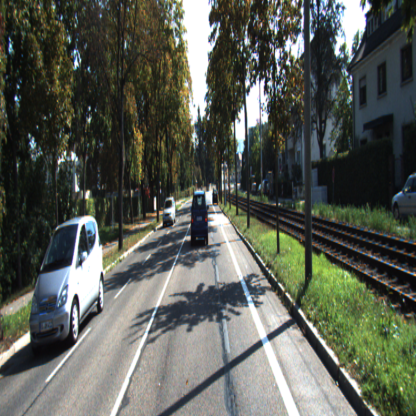

In [8]:
pil_image

In [9]:
y["boxes"].shape

torch.Size([22, 5])

In [10]:
GetBoxes_fn = ln.data.transform.GetAnchorBoxes(
                conf_thresh=0.5,
                network_stride=model.stride,
                anchors=model.anchors
            )

In [11]:
HBB_tensor = GetBoxes_fn(model_output.clone())
HBB_tensor

tensor([[  0.0000, 171.1613, 209.5470,   8.9873,  19.7337,   0.5309,   2.0000],
        [  0.0000, 404.0013, 200.7040,  20.3110,  39.5977,   0.7406,   2.0000],
        [  0.0000, 198.2447, 229.7222,  19.5332,  77.9042,   0.7730,   2.0000],
        [  0.0000,  67.6733, 283.9962,  95.5567, 134.8938,   0.7179,   2.0000],
        [  0.0000,  57.1412, 294.4405, 107.3442, 154.0020,   0.6552,   2.0000]])

In [12]:
nms_fn = ln.data.transform.NMS(
    iou_thresh=.3,
    class_nms=True
)

In [13]:
bbox_nms = nms_fn(HBB_tensor)

In [14]:
bbox = bbox_nms[:,1:5].detach().numpy()

In [15]:
from PIL import Image, ImageDraw
def draw_bounding_boxes(image, boxes):
    """
    Draws bounding boxes on an image and saves the output.
    
    Parameters:
    - image_path (str): Path to the input image.
    - boxes (list of tuples): List of bounding boxes in (x_center, y_center, width, height) format.
    - output_path (str): Path to save the output image with drawn bounding boxes.
    """
    # Open the image
    draw = ImageDraw.Draw(image)

    for box in boxes:
        x_center, y_center, width, height = box

        # Convert (x_center, y_center, width, height) to (left, top, right, bottom)
        left = x_center - width / 2
        top = y_center - height / 2
        right = x_center + width / 2
        bottom = y_center + height / 2

        # Draw the bounding box with a red outline and specified thickness
        draw.rectangle([left, top, right, bottom], outline="red", width=1)

    # Save the output image
    image.show()
    

In [16]:
draw_bounding_boxes(pil_image, bbox, )

In [17]:
calculate_map(model_2, test_dataloader=test_dataloader, nms_function=nms_fn, device=DEVICE)

RuntimeError: boxes should be a 2d tensor, got 3D